In [1]:
# Import essential data analysis and visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

def download_file(file_name, github_path):
    """
    Downloads a file from GitHub to the local environment. If the environment is Google Colab,
    the file is downloaded directly to the current directory. If the environment is local,
    it checks for the file in the '../data/' directory.
    """
    
    if 'google.colab' in str(get_ipython()):
        print(f'Downloading {file_name} from GitHub to Colab environment.')
        !wget --no-check-certificate {github_path} -O {file_name}
        return file_name  # The file will be downloaded to the current directory
    else:
        # For local execution, construct the path relative to the notebook directory
        local_path = os.path.join('..', 'data', file_name)  # Go up one directory and then to the data folder
        if not os.path.exists(local_path):
            raise FileNotFoundError(f"File {file_name} not found at {local_path}. Did you forget to download it?")
        print(f'Using local file {file_name}.')
        return local_path

# URL components for GitHub raw content
github_base_url = 'https://raw.githubusercontent.com/barryfscott/Metformin-Feeding-Lac-Phe-Analysis/main/data/'

# File names to download
files_to_download = [
    'Mathew_feeding_metabolomics.xlsx',
    'unknown_Metabolon_metabolites_renamed.xlsx' 
    # Add more files as needed
]

# Download each file and store the paths
paths_to_files = {}
for file_name in files_to_download:
    github_path = f'{github_base_url}{file_name}'
    file_path = download_file(file_name, github_path)
    paths_to_files[file_name] = file_path


Using local file Mathew_feeding_metabolomics.xlsx.
Using local file unknown_Metabolon_metabolites_renamed.xlsx.


## Data Source and Preparation
The dataset utilized in this study is derived from the paper titled:

**Metabolic changes of the blood metabolome after a date fruit challenge** 
Dataset available [here](https://www.sciencedirect.com/science/article/pii/S1756464618304699). Prior to analysis, certain columns were removed using Excel for a streamlined data import process into a pandas DataFrame.

### Date varieties
- "DATES VARIETY 1" are  "Deglet Nour" Dates
- "DATES VARIETY 2" are "Khlas" Dates


In [2]:
# Load the post-challenge metabolomics data into a dataframe and transpose it
metabolomics_df = pd.read_excel(
    paths_to_files['Mathew_feeding_metabolomics.xlsx'],
    sheet_name="Data_only_metabolite_name",
    index_col=0
).T

# Columns from '1,2,3-benzenetriol sulfate (1)' to 'X - 24932' are converted to floats for numerical analysis
metabolite_data_columns = metabolomics_df.loc[:, '1,2,3-benzenetriol sulfate (1)':'X - 24932'].columns
metabolomics_df[metabolite_data_columns] = metabolomics_df[metabolite_data_columns].astype(float)

# Update metabolite column names by removing the 'retired for' prefix from any column where it appears
metabolomics_df.columns = [
    col.split("retired for ")[1] if "retired for " in col else col for col in metabolomics_df.columns
]


## Metabolite Renaming for Clarity
To enhance the interpretability of the metabolomics data, specific metabolites, particularly N-lactoyl amino acids, were renamed from their originally reported names. This renaming process aids in the clear identification and analysis of these compounds within the dataset. Additionally, a separate list of metabolites identified as 'retired' by Meta

In [3]:
n_lac_metabolite_mapping  ={
"X - 13529":"N-lactoyl valine",
"X - 15497":"N-lactoyl phenylalanine",
"X - 18889":"N-lactoyl leucine",
"X - 22102":"N-lactoyl isoleucine",
"X - 19561":"N-lactoyl tyrosine",
"X - 25607":"N-lactoyl histidine",
    "1-carboxyethylvaline":"N-lactoyl valine",
    "1-carboxyethylphenylalanine":"N-lactoyl phenylalanine",
    "1-carboxyethylleucine":"N-lactoyl leucine",
    "1-carboxyethylisoleucine":"N-lactoyl isoleucine",
    "1-carboxyethyltyrosine":"N-lactoyl tyrosine",
    "1-carboxyethylhistidine":"N-lactoyl histidine"
}

# Rename N-lactoyl metabolite columns using the defined mapping
metabolomics_df.rename(columns=n_lac_metabolite_mapping, inplace=True)

# Load a spreadsheet that contains additional metabolite names that have been updated
metabolites_renamed_df = pd.read_excel(
    paths_to_files["unknown_Metabolon_metabolites_renamed.xlsx"],
    sheet_name="metabolites_renamed"
)

# Create a dictionary for renaming metabolites based on the spreadsheet
updated_metabolite_names = metabolites_renamed_df[
    metabolites_renamed_df["Retired for"].notna()
].set_index("Name")["Retired for"].to_dict()

# Update metabolite column names using the dictionary
metabolomics_df.rename(columns=updated_metabolite_names, inplace=True)

## Normalised by the baseline (pre intervention) for  all volunteers and inteventions

In [4]:
# Select all columns with metabolite data for the analysis
metabolite_data_columns = metabolomics_df.loc[:, '1,2,3-benzenetriol sulfate (1)':'X - 24932'].columns

# Set multi-index using 'SUBJECT_ID', 'TREATMENT', and 'TIME_POINT' and reshape the dataframe
metabolite_time_series_df = metabolomics_df.set_index(["SUBJECT_ID", "TREATMENT", "TIME_POINT"])[metabolite_data_columns]
metabolite_time_series_df = metabolite_time_series_df.stack().unstack("TIME_POINT")

# Reorder columns by time points to maintain a consistent order
time_points_ordered = ['0min', '30min', '60min', '90min', '120min']
metabolite_time_series_df = metabolite_time_series_df.reindex(columns=time_points_ordered)

# Normalize data by dividing by the '0min' time point for each metabolite
normalized_metabolite_data_df = metabolite_time_series_df.div(metabolite_time_series_df["0min"], axis=0)

# Reset the index to turn the multi-index into columns
normalized_metabolite_data_df.reset_index(inplace=True)

normalized_metabolite_data_df.rename(columns ={"level_2":"metabolite"},inplace=True)



## Function for plotting metabolite levels before and after eating, categorized by health status

In [5]:
# Function to plot metabolite levels over time for different treatments
def plot_metabolite(df, metabolite_of_interest, return_df=False):
    # Filter dataframe for the selected metabolite
    metabolite_data = df[df['metabolite'] == metabolite_of_interest]
    
    
    # Define time points for x-axis and treatments for plotting
    time_points = ['0min', '30min', '60min', '90min', '120min']
    treatments = metabolite_data['TREATMENT'].unique()
    
    # Initialize a figure for plotting
    plt.figure(figsize=(12, 8))
    
    # Loop through each treatment and plot the mean and SEM for each time point
    
    for treatment in treatments:
        
        treatment_data = metabolite_data[metabolite_data['TREATMENT'] == treatment]
        means = treatment_data[time_points].mean()
        sems = treatment_data[time_points].sem()
        plt.errorbar(time_points, means, yerr=sems, label=treatment, fmt='-o', capsize=5)

    # Customize the plot with labels and title
    plt.xlabel('Time Point')
    plt.ylabel(metabolite_of_interest)
    plt.title(f'Metabolite {metabolite_of_interest} Levels Over Time by Treatment')
    plt.legend(title='Treatment')
    plt.xticks(time_points, labels=time_points)
    sns.despine()
    
    if return_df:
        return metabolite_data

   


## Analysis of N-lactoyl Phenylalanine (Lac-Phe) Levels in Response to a Date fruit challenge

This visualization presents the variations in N-lactoyl phenylalanine (Lac-Phe) concentrations before and after the consumption of 10 Dates or and Oral Glucose tolerance test. It offers an illustrative comparison with Figure 3e from the original publication, using the same dataset but visualized here via Python’s Matplotlib and Seaborn libraries instead of GraphPad Prism. The individual data points represent subjects' metabolite levels normalised by the baseline, while the bars indicate the mean values for each group.

_To view the code responsible for generating this plot, please refer to the `plot_metabolite` function within the Jupyter notebook._


- Lac-Phe increases up by over 220% with both Date fruit challenges 
- Oral glucose tolerance test (OGTT) only leads to an increase of  37%

TIME_POINT,SUBJECT_ID,0min,30min,60min,90min,120min
TREATMENT,,,,,,
DATES VARIETY 1,84.809524,1.0,1.890297,3.155869,3.237373,2.762554
DATES VARIETY 2,84.400000,1.0,1.823116,3.033725,3.211924,2.920244
OGTT,84.809524,1.0,1.069873,1.245019,1.372920,1.375550


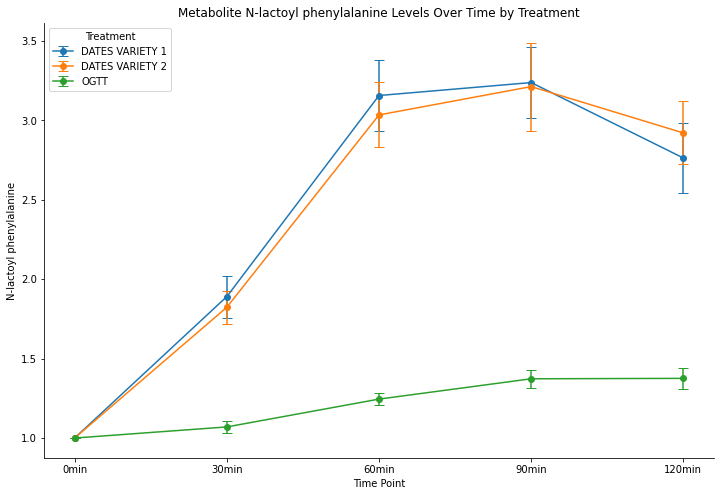

In [6]:
# Analyze and visualize N-lactoyl phenylalanine trends
lac_phe_data = plot_metabolite(normalized_metabolite_data_df, 'N-lactoyl phenylalanine', return_df=True)

# Sort values for a clearer understanding of treatment effects
sorted_lac_phe_data = lac_phe_data.sort_values(by=["TREATMENT", "SUBJECT_ID"])
sorted_lac_phe_data.groupby("TREATMENT").mean()